### Packages and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,boxcox,yeojohnson
import sklearn
from sklearn.preprocessing import LabelEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
#Reading csv
df = pd.read_csv("bank_marketing_weka_dataset.csv")

#Separate features
X = df.drop(['y'], axis=1)

#Target variable
y = df['y']

#Transform 'y' to binary
y = y.map(dict(yes=1, no=0))

In [3]:
#Features initial state
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79.0,1,-1.0,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220.0,1,339.0,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185.0,1,330.0,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199.0,4,-1.0,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226.0,1,-1.0,0,unknown


## Target variable balance

In [4]:
y.value_counts()

0    4000
1     521
Name: y, dtype: int64

# Features engineering

## Continuous variables

In [5]:
conti = X.select_dtypes(include=np.number)
skewed = []
for column in conti.columns:
    if conti[column].skew()>2:
        skewed.append(column)
    print(f'{column.capitalize()} skew = {conti[column].skew()}')

Age skew = 0.6995014533559305
Balance skew = 6.596430546295735
Day skew = 0.09462690455175846
Duration skew = 2.7724197169136455
Campaign skew = 4.74391446894159
Pdays skew = 2.71707136656418
Previous skew = 5.875258677896706


It is known that ML algorithms tend to perform worse if they have to deal with skewed data. Here we arbitrally have chosen to chosen columns with skewness above 2 and transform them, to reduce that parameter.

In [6]:
for column in skewed:
    if X[column].min()>0:
        print(pd.Series(boxcox(X[column])[0]).skew(),f'{column} boxcox')
        X[column] = pd.Series(boxcox(X[column])[0])
    else:
        print(pd.Series(yeojohnson(X[column])[0]).skew(),f'{column} yeojohnson')
        X[column] = pd.Series(yeojohnson(X[column])[0])

1.580521502422124 balance yeojohnson
0.015631020933611555 duration boxcox
0.16509037675445096 campaign boxcox
1.6651521750550364 pdays yeojohnson
1.664879334841969 previous yeojohnson


Ideally we would like to use boxcox transormation for all our chosen data, but this type of transormation does not work with negative values. Instead of trying to add some constant to these columns with non-positive values we decided to use yeojohnson transormation which is capable of dealing with negative data. As we can see in all of our columns we have managed to reduce skewness massively.

## Categorical variables

In [7]:
#List of categorical variables
X.select_dtypes(include='object').columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

### Binary values
Variables: 'default', 'housing', 'loan'\
Values: 'yes', 'no'\
Method: map to yes=1, no=0

In [8]:
X = X.replace('yes', 1)
X = X.replace('no', 0)

### Month variable
Values: string abbreviations\
Method: transform to numerical

In [9]:
X.month = X.month.map(dict(
jan=1, feb=2, mar=3, apr=4, may=5, jun=6,
jul=7, aug=8, sep=9, oct=10, nov=11, dec=12))

### Variables: 'job', 'marital', 'education', 'poutcom', 'contact'

Thanks to EDA we know that:

- 'unknown' values are present
- 'job', 'education', 'poutcom' seem to have impact on target variable
- values distributions have no dangerous disparities (in terms of using the target encoding method)

Hence, we decide to:

 - leave the 'unknown' values, as it represents best the idea of the missing information in our case
 - apply target encoding method to variables related with target variable
 - apply one-hot encoding to other variables
 
Expecting target encoding to reflect the relationship of variables with target variable - where it is present according to EDA - and one-hot method to neutrally pass on values of other variables.

In [10]:
#Target encoding
te = TargetEncoder()
X.loc[:, ['job', 'education', 'poutcome']] = te.fit_transform(X.loc[:, ['job', 'education', 'poutcome']], y)

In [11]:
#One-hot encoding
X = pd.get_dummies(X, columns=['marital', 'contact'])
cols = X.columns

In [12]:
#aktualnie mamy coś takiego
#zrobiłem target enc i one-hot jednocześnie, trochę na "pokaz"
#myślałem czy nie dodać drugiego zbioru gdzie zrobić sam target enc,
#i porównać potem wyniki. Wtedy może na ciągłych też będziesz miał
#taką sytuację i można by zrobić podsumowanie dla kombinacji tych metod
#Bo jak dobrze zrozumiałem to ten checkpoint bardziej polega właśnie
#na zabawie tymi metodami, a te modele tak wstępnie żeby było na czym
#oceniać
X.head(10)

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown
0,30,0.101562,0.094395,0,613.343660,0,0,19,10,6.217047,0.000000,-1.956966,-0.000000,0.090958,0,1,0,1,0,0
1,33,0.091127,0.106245,0,1395.317918,1,1,11,5,8.379996,0.000000,1.589809,0.237020,0.128571,0,1,0,1,0,0
2,35,0.135191,0.142963,0,485.394828,1,0,16,4,7.989852,0.000000,1.589042,0.224505,0.128571,0,0,1,1,0,0
3,30,0.135191,0.142963,0,522.913355,1,1,3,6,8.152847,0.956134,-1.956966,-0.000000,0.090958,0,1,0,0,0,1
4,59,0.072939,0.106245,0,0.000000,1,0,5,5,8.441514,0.000000,-1.956966,-0.000000,0.090958,0,1,0,0,0,1
5,35,0.135191,0.142963,0,296.167564,0,0,23,2,7.398746,0.571901,1.567050,0.236600,0.128571,0,0,1,1,0,0
6,36,0.109290,0.142963,0,140.803457,1,0,14,5,9.414188,0.000000,1.589042,0.234974,0.192893,0,1,0,1,0,0
7,39,0.108073,0.106245,0,75.919768,1,0,6,5,7.545567,0.571901,-1.956966,-0.000000,0.090958,0,1,0,1,0,0
8,41,0.089286,0.142963,0,106.905795,1,0,14,5,5.595942,0.571901,-1.956966,-0.000000,0.090958,0,1,0,0,0,1
9,43,0.091127,0.094395,0,-160.534799,1,1,17,4,9.206514,0.000000,1.559056,0.234974,0.128571,0,1,0,1,0,0


In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Scaling the data just for sake we might use alghoritm that require standarized input.

# Modeling

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [15]:
logistic = LogisticRegressionCV()

In [16]:
kfold = KFold(n_splits=5, random_state=42)
cross_val_score(logistic,X_train,y_train,scoring='accuracy',cv=kfold).mean()

0.8979490000993404

In [17]:
param = {'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'accuracy'

In [18]:
model = xgb.XGBClassifier(param = param)
kfold = KFold(n_splits=7, random_state=7)
cross_val_score(model, X_train, y_train, cv=kfold).mean()

0.8924153530783911

In [19]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              param={'eval_metric': 'accuracy', 'nthread': 4,
                     'objective': 'binary:logistic'},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

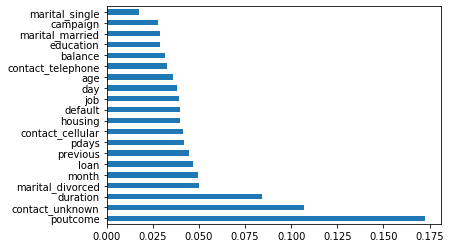

In [20]:
feat_importances = pd.Series(model.feature_importances_, index=cols)
feat_importances.nlargest(20).plot(kind='barh')